In [8]:
-
# Begin here
def process_model_year(model, scenario, year):
    process_year_temps(model, scenario, year)

def process_year_temps(model, scenario, year):
    print(f"Processing temperatures for {model} {year} ({scenario})")
    ids = (gen_netcdf_id(model, scenario, year, 'tasmax'), gen_netcdf_id(model, scenario, year, 'tasmin'))
    print(f"File ids are: {ids}")
    tasmax_file, tasmin_file = list(map(download_file, ids))
    tasmax_dataset, tasmin_dataset = netCDF4.Dataset(tasmax_file), netCDF4.Dataset(tasmin_file)
    print(tasmax_file)
    print(tasmax_dataset)
    print(tasmax_dataset['tasmax'])
    print(tasmax_dataset['tasmax'].shape)
    pass

def gen_netcdf_id(model, scenario, year, var):
    id = f'LOCA/{model}/16th/{scenario}/r1i1p1/{var}/{var}_day_{model}_{scenario}_r1i1p1_{str(year)}0101-{str(year)}1231.LOCA_2016-04-02.16th.nc'
    return id

def download_file(file_id, loca_bucket = loca_bucket, download_location = '/temp'):
    filename = f'{download_location}/{file_id.split("/")[-1]}'
    print(f"Downloading {filename}")
    try:
        s3.Bucket(loca_bucket).download_file(file_id, filename)
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            file_id = file_id.replace('r1i1p1', 'r6i1p1')
            s3.Bucket(loca_bucket).download_file(file_id, filename)
    except:
        filename = None
    return filename

def cleanup():
    for file in glob.glob('/temp/*'):
        os.remove(file)

# Actual processing
def hdd(a, axis):
    a_to_baseline = 291.483 - a
    masked = ma.masked_where(a_to_baseline <= 0, a_to_baseline)
    intermediate_matrix = ma.filled(masked, fill_value = 0)
    result = np.sum(intermediate_matrix, axis = 0)
    return result

## BASELINE

# Average of models per year
def process_baseline_year_tasmax(year, models = all_models, file_prefix = ""):
    print("Generating ids")
    ids = [gen_netcdf_id(model, 'historical', year, 'tasmax') for model in models]
    print("Downloading files")
    pool = Pool()
    filenames = pool.map(download_file, ids)
    # shape = (365, 490, 960)
    print("Stacking files")
    arr_list = list(map(lambda fn: da.from_array(netCDF4.Dataset(fn)['tasmax'], chunks = (366, 245, 240)), filenames))
    arr_stack = da.stack(arr_list)
    print("Calculating average")
    year_avg = np.mean(arr_stack, axis = 0).compute()
    result_filename = f"/temp/{file_prefix}_{year}_tasmax_baseline_average.npy"
    np.save(result_filename, year_avg)
    blob = bucket.blob(f'baseline/tasmax/intermediate/{result_filename.split("/")[-1]}')
    blob.upload_from_filename(result_filename)
    print(result_filename)
    return None

def process_baseline_year_pr(year, models = all_models, file_prefix = ""):
    print("Generating ids")
    ids = [gen_netcdf_id(model, 'historical', year, 'pr') for model in models]
    print("Downloading files")
    pool = Pool()
    filenames = pool.map(download_file, ids)
    # shape = (365, 490, 960)
    print("Stacking files")
    arr_list = list(map(lambda fn: da.from_array(netCDF4.Dataset(fn)['pr'], chunks = (366, 245, 240)), filenames))
    arr_stack = da.stack(arr_list)
    print("Calculating average")
    year_avg = np.mean(arr_stack, axis = 0).compute()
    result_filename = f"/temp/{file_prefix}_{year}_pr_baseline_average.npy"
    np.save(result_filename, year_avg)
    blob = bucket.blob(f'baseline/pr/intermediate/{result_filename.split("/")[-1]}')
    blob.upload_from_filename(result_filename)
    print(result_filename)
    return None


In [ ]:
cleanup()
process_baseline_year_pr(1971, models = all_models, file_prefix = 'test_baseline_v1')

In [ ]:
client.restart()

In [ ]:
for year in range(1986, 2001):
    cleanup()
    process_baseline_year_pr(year, models = all_models, file_prefix = 'baseline_v1')
process_baseline_year_pr(1985, models = all_models, file_prefix = 'baseline_v1')

In [9]:
import itertools

lat_stepsize = int(490 / 5)
lon_stepsize = int(960 / 5)
lat_range = list(range(0, 490, lat_stepsize))
lon_range = list(range(0, 960, lon_stepsize))

lat_slices = [slice(i, i + lat_stepsize) for i in lat_range]
lon_slices = [slice(i, i + lon_stepsize) for i in lon_range]

all_slices = list(map(lambda tup: (slice(None), *tup), itertools.product(lat_slices, lon_slices)))
all_slices

[(slice(None, None, None), slice(0, 98, None), slice(0, 192, None)),
 (slice(None, None, None), slice(0, 98, None), slice(192, 384, None)),
 (slice(None, None, None), slice(0, 98, None), slice(384, 576, None)),
 (slice(None, None, None), slice(0, 98, None), slice(576, 768, None)),
 (slice(None, None, None), slice(0, 98, None), slice(768, 960, None)),
 (slice(None, None, None), slice(98, 196, None), slice(0, 192, None)),
 (slice(None, None, None), slice(98, 196, None), slice(192, 384, None)),
 (slice(None, None, None), slice(98, 196, None), slice(384, 576, None)),
 (slice(None, None, None), slice(98, 196, None), slice(576, 768, None)),
 (slice(None, None, None), slice(98, 196, None), slice(768, 960, None)),
 (slice(None, None, None), slice(196, 294, None), slice(0, 192, None)),
 (slice(None, None, None), slice(196, 294, None), slice(192, 384, None)),
 (slice(None, None, None), slice(196, 294, None), slice(384, 576, None)),
 (slice(None, None, None), slice(196, 294, None), slice(576, 768

In [10]:
len(all_slices)

25

In [13]:
def get_calc_slice(slice_tup, years, var):
    final_slices = []
    for year in years:
        print(f"Getting year {str(year)}")
        year_arr = np.load(f'/temp/intermediate/baseline_v1_{str(year)}_{var}_baseline_average.npy')[slice_tup]
        final_slices.append(np.array(year_arr, copy = True))
        del year_arr
    print("Calculating...")
    return np.percentile(np.concatenate(final_slices, axis = 0), axis = 0, q = 99)
#test_percentile = get_calc_slice(all_slices[12], range(1971, 2001))
#print("Done")

In [14]:
tasmax_baseline_arr = [get_calc_slice(sl, range(1971, 2001), 'tasmax') for sl in all_slices]

Getting year 1971
Getting year 1972
Getting year 1973
Getting year 1974
Getting year 1975
Getting year 1976
Getting year 1977
Getting year 1978
Getting year 1979
Getting year 1980
Getting year 1981
Getting year 1982
Getting year 1983
Getting year 1984
Getting year 1985
Getting year 1986
Getting year 1987
Getting year 1988
Getting year 1989
Getting year 1990
Getting year 1991
Getting year 1992
Getting year 1993
Getting year 1994
Getting year 1995
Getting year 1996
Getting year 1997
Getting year 1998
Getting year 1999
Getting year 2000
Calculating...
Getting year 1971
Getting year 1972
Getting year 1973
Getting year 1974
Getting year 1975
Getting year 1976
Getting year 1977
Getting year 1978
Getting year 1979
Getting year 1980
Getting year 1981
Getting year 1982
Getting year 1983
Getting year 1984
Getting year 1985
Getting year 1986
Getting year 1987
Getting year 1988
Getting year 1989
Getting year 1990
Getting year 1991
Getting year 1992
Getting year 1993
Getting year 1994
Getting year 

Getting year 1995
Getting year 1996
Getting year 1997
Getting year 1998
Getting year 1999
Getting year 2000
Calculating...
Getting year 1971
Getting year 1972
Getting year 1973
Getting year 1974
Getting year 1975
Getting year 1976
Getting year 1977
Getting year 1978
Getting year 1979
Getting year 1980
Getting year 1981
Getting year 1982
Getting year 1983
Getting year 1984
Getting year 1985
Getting year 1986
Getting year 1987
Getting year 1988
Getting year 1989
Getting year 1990
Getting year 1991
Getting year 1992
Getting year 1993
Getting year 1994
Getting year 1995
Getting year 1996
Getting year 1997
Getting year 1998
Getting year 1999
Getting year 2000
Calculating...
Getting year 1971
Getting year 1972
Getting year 1973
Getting year 1974
Getting year 1975
Getting year 1976
Getting year 1977
Getting year 1978
Getting year 1979
Getting year 1980
Getting year 1981
Getting year 1982
Getting year 1983
Getting year 1984
Getting year 1985
Getting year 1986
Getting year 1987
Getting year 198

In [58]:
final_pr_result = np.concatenate(list(map(lambda row: np.concatenate(row, axis = 1), [baseline_arr[i:i+5] for i in range(0, 25, 5)])), axis = 0)
final_pr_result[final_pr_result > 100] = 0

In [17]:
final_tasmax_result = np.concatenate(list(map(lambda row: np.concatenate(row, axis = 1), [tasmax_baseline_arr[i:i+5] for i in range(0, 25, 5)])), axis = 0)
final_tasmax_result[final_tasmax_result > 1000] = 0

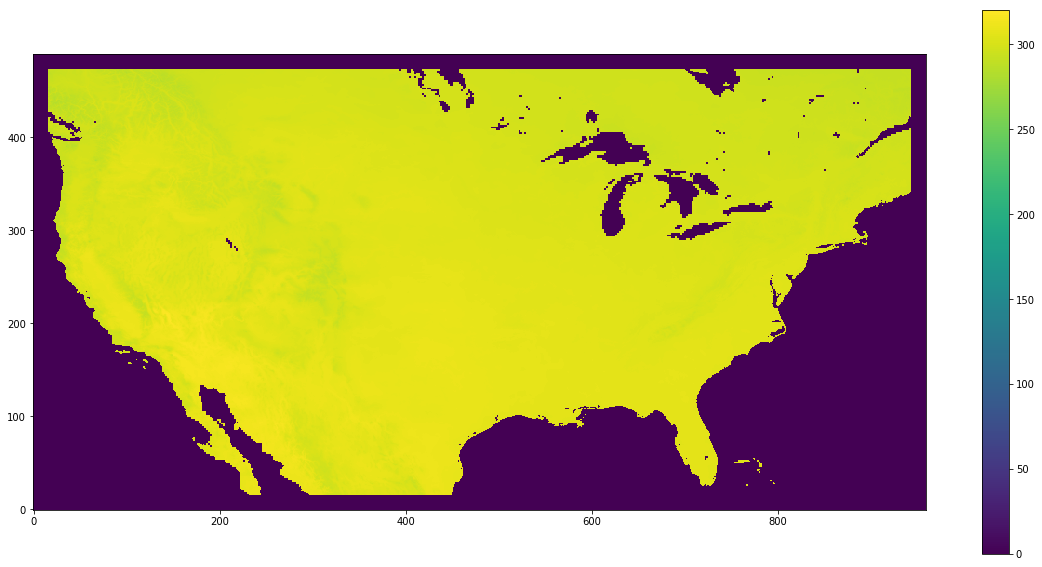

In [18]:
plt.figure(figsize=(20, 10))
plt.imshow(final_tasmax_result, origin = 'lower')
plt.colorbar()

In [63]:
np.save('baseline_loca_pr.npy', final_pr_result)

In [19]:
np.save('baseline_loca_tasmax.npy', final_tasmax_result)